In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/class-sep-matrices-20-pat/X_rh_nf.npy
/kaggle/input/class-sep-matrices-20-pat/X_lh_nf.npy
/kaggle/input/class-sep-matrices-20-pat/X_lh_adapted.npy
/kaggle/input/class-sep-matrices-20-pat/X_rh_f.npy
/kaggle/input/class-sep-matrices-20-pat/X_rh_adapted.npy
/kaggle/input/class-sep-matrices-20-pat/X_lh_f.npy
/kaggle/input/p-50-processed-matrices/data_r_f.npy
/kaggle/input/p-50-processed-matrices/data_r_nf.npy
/kaggle/input/p-50-processed-matrices/data_l_f.npy
/kaggle/input/p-50-processed-matrices/data_l_nf.npy
/kaggle/input/generator-1/g_model_AtoB_001360.h5
/kaggle/input/generators-20-patients/losses.csv
/kaggle/input/generators-20-patients/g_model_AtoB_020500.h5
/kaggle/input/generators-20-patients/g_model_BtoA_020500.h5
/kaggle/input/generators-20-patients-lh/g_model_BtoA_022680.h5
/kaggle/input/generators-20-patients-lh/losses (2).csv
/kaggle/input/generators-20-patients-lh/g_model_AtoB_022680.h5
/kaggle/input/f-nf-matrices-20-patients/P18_X_rh_nf.npy
/kaggle/input/f-nf-m

In [3]:
import tensorflow.keras.backend as K
import numpy as np
from scipy import signal
import tensorflow as tf


def power_and_mae_loss(y_true, y_pred):
    # Define the frequency bands you want to consider (e.g., alpha, delta, theta, and beta)
    # You need to adjust the frequency range and indices based on your specific requirements
    alpha_indices = range(8, 13)
    delta_indices = range(0.5, 4)
    theta_indices = range(4, 8)
    beta_indices = range(13,30)

    # Apply the FFT to the predicted signal (y_pred)
    y_pred_fft = K.fft(y_pred)

    # Calculate the power in each frequency band
    alpha_power = K.mean(K.square(K.abs(y_pred_fft[:, alpha_indices])))
    delta_power = K.mean(K.square(K.abs(y_pred_fft[:, delta_indices])))
    theta_power = K.mean(K.square(K.abs(y_pred_fft[:, theta_indices])))
    beta_power = K.mean(K.square(K.abs(y_pred_fft[:, beta_indices])))

    # Calculate the average power across all bands
    average_power = (alpha_power + delta_power + theta_power + beta_power) / 4.0

    # Calculate the Mean Absolute Error (MAE) between y_true and y_pred
    mae = K.mean(K.abs(y_true - y_pred))

    # Define weighting factors for the power loss and MAE loss
    # You may need to adjust these factors based on your specific problem
    power_weight = 0.1
    mae_weight = 0.9

    # Calculate the combined loss as a weighted sum of power loss and MAE loss
    combined_loss = (power_weight * average_power) + (mae_weight * mae)

    return combined_loss

def power_and_mae_loss_1(y_true, y_pred):
#normal method...Im not going for the Welsh method
    print(y_true.shape)
    print(y_pred.shape)
    frequency_bands = {
        'alpha': (8, 13),
        'delta': (0.5, 4),
        'theta': (4, 8),
        'beta': (13, 30)
    }

    # Calculate the power for each trial, channel, and frequency band
    signal_length, num_channels = K.int_shape(y_true)[1:]
    X = np.zeros( (4*num_channels))
    X_ = np.zeros( (4*num_channels))

  
    for channel in range(num_channels):
        for band_idx, (band, (f_low, f_high)) in enumerate(frequency_bands.items()):
            # Apply a bandpass filter to the segment using TensorFlow function
            b = tf.constant([f_low / 250, f_high / 250], dtype=tf.float32)
            a = tf.constant([1.0], dtype=tf.float32)
            filtered_segment = tf.signal.filtfilt(b, a, tf.squeeze(y_true[:, channel], axis=-1))
            filtered_segment_ = tf.signal.filtfilt(b, a, tf.squeeze(y_pred[:, channel], axis=-1))

            # Calculate the power using the squared absolute values of the filtered segment
            power = tf.reduce_mean(tf.abs(filtered_segment) ** 2)
            power_ = tf.reduce_mean(tf.abs(filtered_segment_) ** 2)

            # Store the power in the output matrix X
            X[channel * len(frequency_bands) + band_idx] = power.numpy()
            X_[channel * len(frequency_bands) + band_idx] = power_.numpy()

    power_loss = K.maximum(0, K.abs(K.mean(X, axis=0) - K.mean(X_, axis=0)))
    mae = K.mean(K.abs(y_true - y_pred))

    # Define weighting factors for the power loss and MAE loss
    # You may need to adjust these factors based on your specific problem
    power_weight = 0.1
    mae_weight = 0.9

    # Calculate the combined loss as a weighted sum of power loss and MAE loss
    combined_loss = (power_weight * power_loss) + (mae_weight * mae)

    return combined_loss

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
import csv

def save_losses_to_csv(loss_data, filepath):
    with open(filepath, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header row
        writer.writerow(["Iteration", "dA_loss1", "dA_loss2", "dB_loss1", "dB_loss2", "g_loss1", "g_loss2"])
        # Write the loss data
        writer.writerows(loss_data)

In [5]:
"""
cycleGAN model

Based on the code by Jason Brownlee from his blogs on https://machinelearningmastery.com/
I am adapting his code to various applications but original credit goes to Jason. 

The model uses instance normalization layer:
Normalize the activations of the previous layer at each step,
i.e. applies a transformation that maintains the mean activation
close to 0 and the activation standard deviation close to 1.
Standardizes values on each output feature map rather than across features in a batch. ​

Download instance normalization code from here: https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/normalization/instancenormalization.py
Or install keras_contrib using guidelines here: https://github.com/keras-team/keras-contrib 
"""

#
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Conv1DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
import tensorflow as tf
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

#Download instance norm. code from the link above.
#Or install keras_contrib using guidelines here: https://github.com/keras-team/keras-contrib 
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization  

from matplotlib import pyplot

# discriminator model (70x70 patchGAN)
# C64-C128-C256-C512
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.  
# The “axis” argument is set to -1 for instance norm. to ensure that features are normalized per feature map.
def define_discriminator(image_shape):
    # weight initialization
        init = RandomNormal(stddev=0.02)
        # source image input
        in_image = Input(shape=image_shape)
        # C64: 4x4 kernel Stride 2x2
        d = Conv1D(64, 7, strides=1, padding='same', kernel_initializer=init)(in_image)
        d = LeakyReLU(alpha=0.2)(d)
        # C128: 4x4 kernel Stride 2x2
        d = Conv1D(64, 7, strides=2, padding='same', kernel_initializer=init)(d)
        d = InstanceNormalization(axis=-1)(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C256: 4x4 kernel Stride 2x2
        d = Conv1D(256, 3, strides=2, padding='same', kernel_initializer=init)(d)
        d = InstanceNormalization(axis=-1)(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C512: 4x4 kernel Stride 2x2 
        # Not in the original paper. Comment this block if you want.
        d = Conv1D(512, 3, strides=2, padding='same', kernel_initializer=init)(d)
        d = InstanceNormalization(axis=-1)(d)
        d = LeakyReLU(alpha=0.2)(d)
        # patch output
        patch_out = Conv1D(1,3, padding='same', kernel_initializer=init)(d)
        # define model
        model = Model(in_image, patch_out)
        # compile model
        #The model is trained with a batch size of one image and Adam opt. 
        #with a small learning rate and 0.5 beta. 
        #The loss for the discriminator is weighted by 50% for each model update.
        #This slows down changes to the discriminator relative to the generator model during training.
        model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
        return model

# generator a resnet block to be used in the generator
# residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.
def resnet_block(n_filters, input_layer):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # first convolutional layer
        g = Conv1D(n_filters, 3, padding='same', kernel_initializer=init)(input_layer)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # second convolutional layer
        g = Conv1D(n_filters, 3, padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        # concatenate merge channel-wise with input layer
        g = Concatenate()([g, input_layer])
        return g

# define the  generator model - encoder-decoder type architecture

#c7s1-k denote a 7×7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1. 
#dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2.
# Rk denotes a residual block that contains two 3 × 3 convolutional layers
# uk denotes a 3 × 3 fractional-strided-Convolution InstanceNorm-ReLU layer with k filters and stride 1/2

#The network with 6 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3

#The network with 9 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

def define_generator(image_shape, n_resnet=5):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=image_shape)
        # c7s1-64
        g = Conv1D(64, 7, padding='same', kernel_initializer=init)(in_image)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # d128
        g = Conv1D(128, 3, strides=2, padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # d256
        g = Conv1D(256, 3, strides=2, padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # R256
        g = Conv1D(512, 3, strides=2, padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        
        for _ in range(n_resnet):
            g = resnet_block(512, g)
        # u128
        g = Conv1DTranspose(256, 3, strides=2, padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # u64
        g = Conv1DTranspose(128, 3, strides=2, padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # c7s1-3
        g = Conv1DTranspose(64, 3, strides=2, padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        
        g = Conv1D(5, 3, padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        out_image = Activation('tanh')(g)
        #out_image = tf.keras.layers.Cropping1D(cropping=(1, 1))(out_image)
        # define model
        model = Model(in_image, out_image)
        return model

# define a composite model for updating generators by adversarial and cycle loss
#We define a composite model that will be used to train each generator separately. 
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
        # Make the generator of interest trainable as we will be updating these weights.
        #by keeping other models constant.
        #Remember that we use this same function to train both generators,
        #one generator at a time. 
        g_model_1.trainable = True
        # mark discriminator and second generator as non-trainable
        d_model.trainable = False
        g_model_2.trainable = False

        # adversarial loss
        input_gen = Input(shape=image_shape)
        gen1_out = g_model_1(input_gen)
        output_d = d_model(gen1_out)
        # identity loss
        input_id = Input(shape=image_shape)
        output_id = g_model_1(input_id)
        # cycle loss - forward
        output_f = g_model_2(gen1_out)
        # cycle loss - backward
        gen2_out = g_model_2(input_id)
        output_b = g_model_1(gen2_out)

        # define model graph
        model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

        # define the optimizer
        opt = Adam(lr=0.0002, beta_1=0.5)
        # compile model with weighting of least squares loss and L1 loss
        model.compile(loss=['mse', 'mae', 'mae', 'mae'], 
                   loss_weights=[1, 5, 10, 10], optimizer=opt)
        return model

# load and prepare training images
def load_real_samples(filename):
        # load the dataset
        data = load(filename)
        # unpack arrays
        X1, X2 = data['arr_0'], data['arr_1']
        # scale from [0,255] to [-1,1]
        #X1 = (X1 - 127.5) / 127.5
        #X2 = (X2 - 127.5) / 127.5
        return [X1, X2]

# select a batch of random samples, returns images and target
#Remember that for real images the label (y) is 1. 
def generate_real_samples(dataset, n_samples, patch_shape):
        # choose random instances
        ix = randint(0, dataset.shape[0], n_samples)
        # retrieve selected images
        X = dataset[ix]
        # generate 'real' class labels (1)
        y = ones((n_samples, patch_shape, patch_shape, 1))
        return X, y

# generate a batch of images, returns images and targets
#Remember that for fake images the label (y) is 0. 
def generate_fake_samples(g_model, dataset, patch_shape):
        # generate fake images
        X = g_model.predict(dataset)
        # create 'fake' class labels (0)
        y = zeros((len(X), patch_shape, patch_shape, 1))
        return X, y

# periodically save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
        # save the first generator model
        filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
        g_model_AtoB.save(filename1)
        # save the second generator model
        filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
        g_model_BtoA.save(filename2)
        print('>Saved: %s and %s' % (filename1, filename2))

# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
        # select a sample of input images
        X_in, _ = generate_real_samples(trainX, n_samples, 0)
        # generate translated images
        X_out, _ = generate_fake_samples(g_model, X_in, 0)
        # scale all pixels from [-1,1] to [0,1]
        X_in = (X_in + 1) / 2.0
        X_out = (X_out + 1) / 2.0
        # plot real images
        for i in range(n_samples):
            pyplot.subplot(2, n_samples, 1 + i)
            pyplot.axis('off')
            pyplot.imshow(X_in[i])
        # plot translated image
        for i in range(n_samples):
            pyplot.subplot(2, n_samples, 1 + n_samples + i)
            pyplot.axis('off')
            pyplot.imshow(X_out[i])
        # save plot to file
        filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
        pyplot.savefig(filename1)
        pyplot.close()

# update image pool for fake images to reduce model oscillation
# update discriminators using a history of generated images 
#rather than the ones produced by the latest generators.
#Original paper recommended keeping an image buffer that stores 
#the 50 previously created images.

def update_image_pool(pool, images, max_size=50):
        selected = list()
        for image in images:
            if len(pool) < max_size:
                # stock the pool
                pool.append(image)
                selected.append(image)
            elif random() < 0.5:
                # use image, but don't add it to the pool
                selected.append(image)
            else:
                # replace an existing image and use replaced image
                ix = randint(0, len(pool))
                selected.append(pool[ix])
                pool[ix] = image
        return asarray(selected)

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
        save_path="/kaggle/working/"
        # define properties of the training run
        n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
        # determine the output square shape of the discriminator
        n_patch = d_model_A.output_shape[1]
        # unpack dataset
        trainA, trainB = dataset
        # prepare image pool for fake images
        poolA, poolB = list(), list()
        # calculate the number of batches per training epoch
        bat_per_epo = int(len(trainA) / n_batch)
        # calculate the number of training iterations
        n_steps = bat_per_epo * n_epochs

        # manually enumerate epochs
        for i in range(n_steps):
            # select a batch of real samples from each domain (A and B)
            X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
            X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
            # generate a batch of fake samples using both B to A and A to B generators.
            X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
            X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
            # update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)

            # update generator B->A via the composite model
            g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
            # update discriminator for A -> [real/fake]
            dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

            # update generator A->B via the composite model
            g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
            # update discriminator for B -> [real/fake]
            dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

            # summarize performance
            #Since our batch size =1, the number of iterations would be same as the size of our dataset.
            #In one epoch you'd have iterations equal to the number of images.
            #If you have 100 images then 1 epoch would be 100 iterations
            print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
            losses = []
            losses.append([i+1, dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2])
            save_losses_to_csv(losses, os.path.join(save_path, 'losses.csv'))
            # evaluate the model performance periodically
            #If batch size (total images)=100, performance will be summarized after every 75th iteration.
            """
            if (i+1) % (bat_per_epo * 1) == 0:
                # plot A->B translation
                summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
                # plot B->A translation
                summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
                
            """
            if (i+1) % (bat_per_epo * 10) == 0:
                # save the models
                # #If batch size (total images)=100, model will be saved after 
                #every 75th iteration x 5 = 375 iterations.
                save_models(i, g_model_AtoB, g_model_BtoA)


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
model = define_generator((1000,5))
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 5)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1000, 64)     2304        ['input_1[0][0]']                
                                                                                                  
 instance_normalization (Instan  (None, 1000, 64)    128         ['conv1d[0][0]']                 
 ceNormalization)                                                                                 
                                                                                                  
 activation (Activation)        (None, 1000, 64)     0           ['instance_normalization[0][0

In [6]:
from os import listdir
from numpy import asarray
from numpy import vstack
from matplotlib import pyplot as plt
import numpy as np

In [11]:
path = "/kaggle/input/f-nf-matrices-20-patients"
for filename in os.listdir(path):
       if filename.endswith(".npy"):    
            file_path = os.path.join(path,filename)

            data = np.load(file_path)
            print(data.shape)
            #data = np.swapaxes(data,1,2)
            print(filename.split('.')[0].split('_')[-2])
            break


(19, 5, 1000)
rh


In [6]:
# load all data in a directory into memory
# I'm considering data from the right habd only in this case
def load_data(path, size=(1000,5)):
        data_list = list()
        # enumerate filenames in directory, assume all are images
        for filename in listdir(path):
            # load and resize the image
            array = np.load(path)
            # store
            data_list.append(pixels)
        return asarray(data_list)
    
path  = "/kaggle/input/f-nf-matrices-20-patients"
dataA_all = []
dataB_all = []

#print("*******",foldername,"********")
for filename in os.listdir(path):

        if filename.endswith(".npy"):    
            file_path = os.path.join(path,filename)

            data = np.load(file_path)
            data = np.swapaxes(data,1,2)
            if(filename.split('.')[0].split('_')[-2]=='lh'):
                if(filename.split('.')[0].split('_')[-1]=='nf'):
                    dataB_all.append(data)
                else:
                    dataA_all.append(data)
"""
for foldername in os.listdir(path):
    #print("*******",foldername,"********")
    for filename in os.listdir(os.path.join(path,foldername)):

        if filename.endswith(".npy"):    
            file_path = os.path.join(path,foldername,filename)

            data = np.load(file_path)
            data = np.swapaxes(data,1,2)
            if(filename.split('.')[0].split('_')[-2]=='r'):
                if(filename.split('.')[0].split('_')[-1]=='nf'):
                    dataB_all.append(data)
                else:
                    dataA_all.append(data)
"""
            
dataB_all = np.concatenate(dataB_all, axis=0)
dataA_all = np.concatenate(dataA_all, axis=0)
print(dataB_all.shape)
print(dataA_all.shape)

(316, 1000, 5)
(84, 1000, 5)


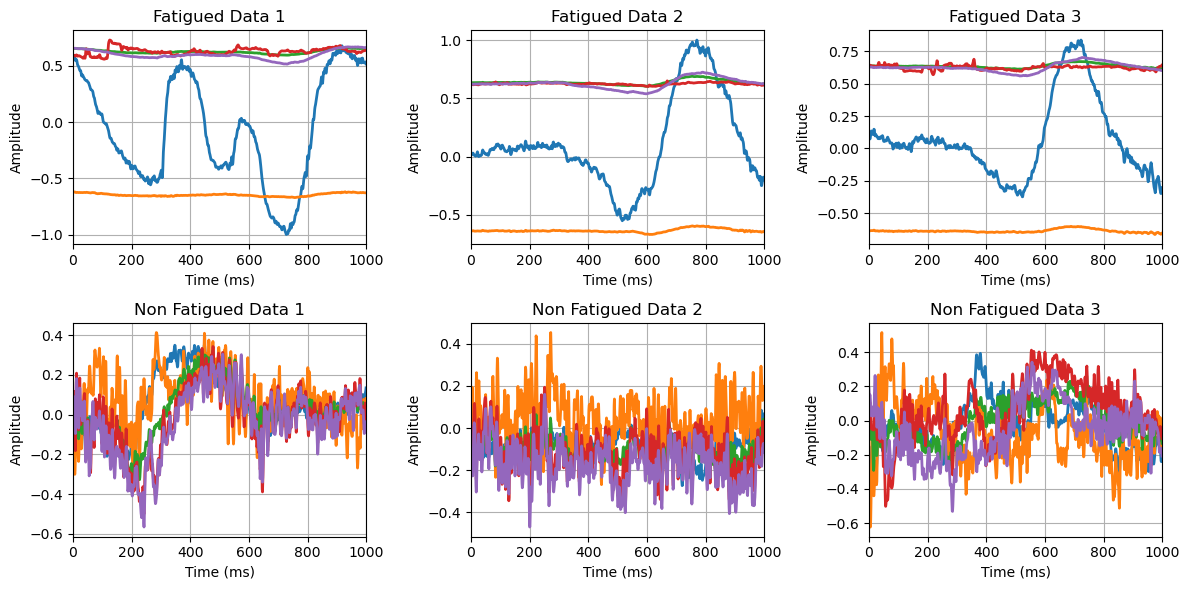

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define the figure size (width, height) in inches
fig = plt.figure(figsize=(12, 6))

# Plot source data
n_samples = 3
for i in range(n_samples):
    ax = fig.add_subplot(2, n_samples, 1 + i)
    ax.set_xlim(0, len(dataA_all[i]))  # Adjust the x-axis limits if needed
    ax.set_xlabel('Time (ms)')  # Label for the x-axis
    ax.set_ylabel('Amplitude')  # Label for the y-axis
    ax.grid(True)  # Enable grid lines
    ax.plot(dataA_all[i], linewidth=2)  # Adjust line width if needed
    ax.set_title('Fatigued Data %d' % (i + 1))

# Plot target image
for i in range(n_samples):
    ax = fig.add_subplot(2, n_samples, 1 + n_samples + i)
    ax.set_xlim(0, len(dataB_all[i]))  # Adjust the x-axis limits if needed
    ax.set_xlabel('Time (ms)')  # Label for the x-axis
    ax.set_ylabel('Amplitude')  # Label for the y-axis
    ax.grid(True)  # Enable grid lines
    ax.plot(dataB_all[i], linewidth=2)  # Adjust line width if needed
    ax.set_title('Non Fatigued Data %d' % (i + 1))

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
dataset = [dataA_all, dataB_all]
print('Loaded', dataset[0].shape, dataset[1].shape)

Loaded (84, 1000, 5) (316, 1000, 5)


In [ ]:
 #from cycleGAN_model import define_generator, define_discriminator, define_composite_model, train
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=2000)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 1s 821ms/step
Iteration>1, dA[0.543,0.236] dB[0.465,0.304] g[14.652,15.027]
1/1 [==============================] - 0s 19ms/step
Iteration>2, dA[0.404,0.219] dB[0.497,0.222] g[14.053,14.330]
1/1 [==============================] - 0s 20ms/step
Iteration>3, dA[0.913,0.220] dB[0.526,0.204] g[13.939,15.036]
1/1 [==============================] - 0s 19ms/step
Iteration>4, dA[0.944,0.180] dB[0.814,0.220] g[12.672,13.759]
1/1 [==============================] - 0s 19ms/step
Iteration>5, dA[0.481,0.178] dB[0.455,0.222] g[12.077,13.346]
1/1 [==============================] - 0s 19ms/step
Iteration>6, dA[0.268,0.174] dB[1.288,0.223] g[11.004,12.343]
1/1 [==============================] - 0s 19ms/step
Iteration>7, dA[0.231,0.185] dB[0.362,0.197] g[10.324,11.619]
1/1 [==============================] - 0s 19ms/step
Iteration>8, dA[0.272,0.200] dB[0.221,0.243] g[9.443,10.386]
1/1 [==============================] - 0s 20ms/step
Iteration>9, dA[0.268,0.196] dB[0.38

In [6]:
os.chdir(r'/kaggle/working')

In [8]:
!ls

g_model_AtoB_000420.h5	g_model_AtoB_015540.h5	g_model_BtoA_008400.h5
g_model_AtoB_000840.h5	g_model_AtoB_015960.h5	g_model_BtoA_008820.h5
g_model_AtoB_001260.h5	g_model_AtoB_016380.h5	g_model_BtoA_009240.h5
g_model_AtoB_001680.h5	g_model_AtoB_016800.h5	g_model_BtoA_009660.h5
g_model_AtoB_002100.h5	g_model_AtoB_017220.h5	g_model_BtoA_010080.h5
g_model_AtoB_002520.h5	g_model_AtoB_017640.h5	g_model_BtoA_010500.h5
g_model_AtoB_002940.h5	g_model_AtoB_018060.h5	g_model_BtoA_010920.h5
g_model_AtoB_003360.h5	g_model_AtoB_018480.h5	g_model_BtoA_011340.h5
g_model_AtoB_003780.h5	g_model_AtoB_018900.h5	g_model_BtoA_011760.h5
g_model_AtoB_004200.h5	g_model_AtoB_019320.h5	g_model_BtoA_012180.h5
g_model_AtoB_004620.h5	g_model_AtoB_019740.h5	g_model_BtoA_012600.h5
g_model_AtoB_005040.h5	g_model_AtoB_020160.h5	g_model_BtoA_013020.h5
g_model_AtoB_005460.h5	g_model_AtoB_020580.h5	g_model_BtoA_013440.h5
g_model_AtoB_005880.h5	g_model_AtoB_021000.h5	g_model_BtoA_013860.h5
g_model_AtoB_006300.h5	g_model_Ato

In [12]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/g_model_AtoB_003780.h5')

/kaggle/working/g_model_AtoB_003780.h5

In [13]:
model_AtoB  = g_model_AtoB

NameError: name 'g_model_AtoB' is not defined

In [8]:
###########################################

# Use the saved cyclegan models for image translation
#from instancenormalization import InstanceNormalization  
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint
from sklearn.utils import resample

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X


# load the models
#cust = {'InstanceNormalization': InstanceNormalization}
g_model_AtoB = load_model('/kaggle/input/generators-20-patients-lh/g_model_AtoB_022680.h5')
g_model_BtoA = load_model('/kaggle/input/generators-20-patients-lh/g_model_BtoA_022680.h5')
#g_model_AtoB = tf.keras.models.load_model('/kaggle/input/generator-1/g_model_AtoB_001360.h5')
# plot A->B->A (Monet to photo to Monet)


/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


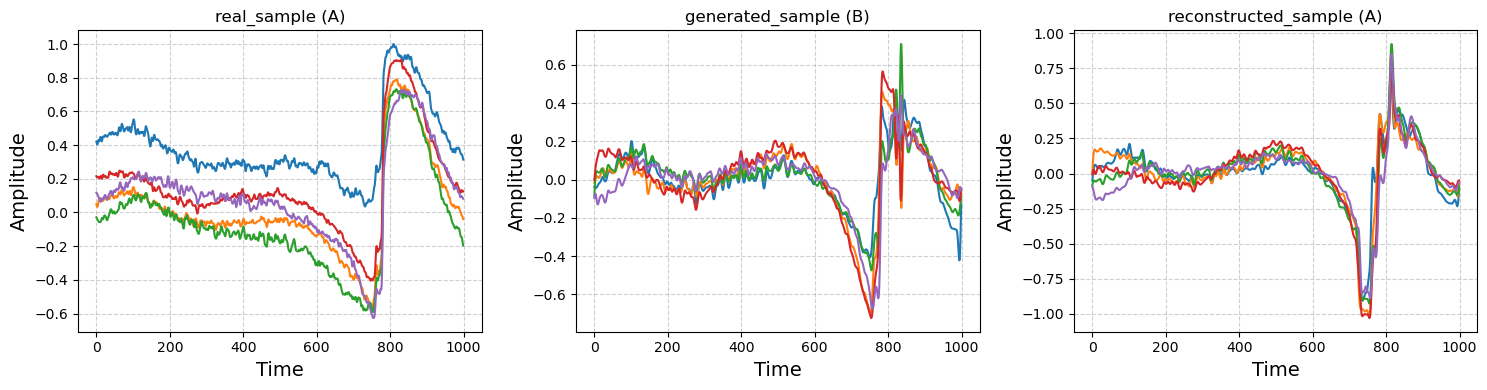

In [9]:
import scipy.signal as signal
# load dataset
A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=16,    
                 #random_state=42
                 ) # reproducible results

B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=16,    
                # random_state=42
                 ) # reproducible results

A_real = select_sample(A_data, 1)
B_generated  = g_model_AtoB.predict(A_real)
A_reconstructed = g_model_BtoA.predict(B_generated)

def filter_data(data,f_low=0.5,f_high=35,rate=200):
    # Design the bandpass filter
    b, a = signal.butter(4, [f_low / rate, f_high / rate], btype='band')
    return signal.filtfilt(b, a, data, axis=0)

# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)

axs[0].plot(np.squeeze(A_real,axis=0))
axs[0].set_title('real_sample (A)')
axs[1].plot(filter_data(np.squeeze(B_generated,axis=0)))
axs[1].set_title('generated_sample (B)')
axs[2].plot(filter_data(np.squeeze(A_reconstructed,axis=0)))
axs[2].set_title('reconstructed_sample (A)')
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
from scipy import signal

# Assuming you have EEG data stored in a numpy array called 'eeg_data'
# with shape (number of trials, num channels, length of signal)

# Define the frequency bands of interest
def bandpower_per_channel_2(eeg_data,gen=True):
    
    frequency_bands = {
        'alpha': (8, 13),
        'delta': (0.5, 4),
        'theta': (4, 8),
        'beta': (13, 30)
    }

    # Calculate the power for each trial, channel, and frequency band
    num_trials,signal_length,num_channels = eeg_data.shape
    X = np.zeros((num_trials,4*num_channels))
    for trial in range(num_trials):
        if(gen==True):
            A_generated = np.squeeze(g_model_AtoB.predict(np.expand_dims(eeg_data[trial],axis=0)),axis=0)
        else:
            A_generated=eeg_data[trial]
            
        for channel in range(num_channels):
            for band_idx, (band, (f_low, f_high)) in enumerate(frequency_bands.items()):
                # Apply a bandpass filter to the segment
                b, a = signal.butter(4, [f_low / 200, f_high / 200], btype='band')
                filtered_segment = signal.filtfilt(b, a, A_generated[:,channel])

                # Calculate the power using the squared absolute values of the filtered segment
                power = np.mean(np.abs(filtered_segment) ** 2)

                # Store the power in the output matrix X
                X[trial, channel * len(frequency_bands) + band_idx] = power

                    # Print the output matrix X
    print("Output shape:", X.shape)
    return X


In [15]:
X_lh_adapted = bandpower_per_channel_2(dataA_all,gen=True)

1/1 [==============================] - 0s 84ms/step
Output shape: (84, 20)


array([[9.09421823e-05, 1.77972481e-02, 2.18572101e-04, ...,
        4.72666325e-02, 1.71143231e-04, 5.14911583e-04],
       [1.62980153e-04, 6.88867680e-02, 8.49370786e-04, ...,
        5.38077980e-02, 3.59368067e-04, 3.98834783e-04],
       [4.85899044e-04, 1.62428556e-02, 1.32319523e-03, ...,
        2.03560847e-02, 4.99993138e-04, 3.20687782e-04],
       ...,
       [2.16431188e-03, 5.41610040e-03, 3.03604851e-03, ...,
        2.07026696e-02, 2.11522329e-03, 7.45282658e-03],
       [1.17349346e-03, 1.29950929e-02, 6.27975196e-03, ...,
        1.55863631e-02, 1.48680604e-03, 6.40527943e-03],
       [1.81233840e-03, 1.51001931e-02, 5.16285418e-03, ...,
        7.55861962e-03, 3.16596890e-03, 6.85001026e-03]])

In [16]:
np.save("/kaggle/working/X_lh_adapted",X_lh_adapted)

In [46]:
X_fat =bandpower_per_channel_2(np.squeeze(A_real))
X_nfat = bandpower_per_channel_2(filter_data(np.squeeze(B_generated)))

Output shape: (1, 20)
Output shape: (1, 20)


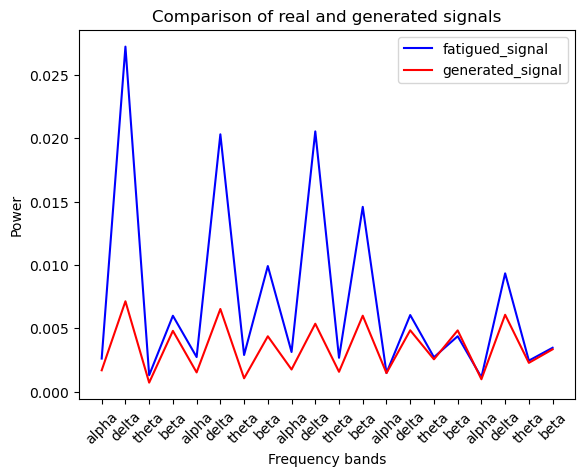

In [47]:
x_labels = ['alpha', 'delta', 'theta', 'beta'] * 5

# Generate two sample matrices
matrix1 = X_fat
matrix2 = X_nfat

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the first matrix
ax.plot(matrix1.flatten(), 'b-', label='fatigued_signal')

# Plot the second matrix
ax.plot(matrix2.flatten(), 'r-', label='generated_signal')

# Customize the x-axis labels
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45)

# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('Frequency bands')
ax.set_ylabel('Power')
ax.set_title('Comparison of real and generated signals')

# Show the plot
plt.show()

In [2]:
from scipy import signal

# Assuming you have EEG data stored in a numpy array called 'eeg_data'
# with shape (number of trials, num channels, length of signal)

# Define the frequency bands of interest
def bandpower_per_channel(eeg_data):
#normal method...Im not going for the Welsh method
    frequency_bands = {
        'alpha': (8, 13),
        'delta': (0.5, 4),
        'theta': (4, 8),
        'beta': (13, 30)
    }

    # Calculate the power for each trial, channel, and frequency band
    num_trials, num_channels, signal_length = eeg_data.shape
    X = np.zeros((num_trials, 4*num_channels))

    for trial in range(num_trials):
        for channel in range(num_channels):
            for band_idx, (band, (f_low, f_high)) in enumerate(frequency_bands.items()):
                # Apply a bandpass filter to the segment
                b, a = signal.butter(4, [f_low / 250, f_high / 250], btype='band')
                filtered_segment = signal.filtfilt(b, a, eeg_data[trial, channel])

                # Calculate the power using the squared absolute values of the filtered segment
                power = np.mean(np.abs(filtered_segment) ** 2)

                # Store the power in the output matrix X
                X[trial, channel * len(frequency_bands) + band_idx] = power

                # Print the output matrix X
    print("Output shape:", X.shape)
    return X

In [7]:
path = "/kaggle/input/class-sep-matrices-20-pat/"
X_rh_f = np.load(path + "X_rh_f.npy")
X_lh_f = np.load(path + "X_lh_f.npy")
X_lh_adapted  =np.load(path + "X_lh_adapted.npy")
X_rh_nf = np.load(path + "X_rh_nf.npy")
X_lh_nf = np.load(path + "X_lh_nf.npy")
X_rh_adapted = np.load(path + "X_rh_adapted.npy")

In [8]:
X_rh_f.shape

(100, 20)

In [16]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances




# Calculate Dunn's Index
def calculate_dunns_index(cluster1, cluster2):
    inter_cluster_distances = euclidean_distances(cluster1, cluster2)
    min_inter_cluster_distance = np.min(inter_cluster_distances)
    
    intra_cluster_distances = []
    for cluster in [cluster1, cluster2]:
        mean_cluster = np.mean(cluster, axis=0)
        intra_cluster_distance = np.sqrt(np.sum((cluster - mean_cluster)**2, axis=1))
        intra_cluster_distances.append(intra_cluster_distance)
    max_intra_cluster_distance = np.max(np.concatenate(intra_cluster_distances))
    
    return min_inter_cluster_distance / max_intra_cluster_distance




# Calculate Fisher Score
def calculate_fisher_score(feature, class1, class2):
            mean_class1 = np.mean(class1[:, feature])
            mean_class2 = np.mean(class2[:, feature])

            stddev_class1 = np.std(class1[:, feature])
            stddev_class2 = np.std(class2[:, feature])

            between_class_scatter = (mean_class1 - mean_class2)**2
            within_class_scatter = (stddev_class1**2 + stddev_class2**2) / 2

            return between_class_scatter / within_class_scatter
def get_fisher_score(X_fat,X_nfat):
    num_features = X_fat.shape[1]
    fisher_score = 0
    for feature in range(num_features):
        fisher_score = fisher_score + calculate_fisher_score(feature, X_fat, X_nfat)
    return fisher_score/num_features


In [18]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Assuming X and X' are your data matrices for class 1 and class 2, respectively.
# Let's say X has n1 samples and X' has n2 samples.

# Step 1: Calculate pairwise Euclidean distances within each class
def get_fisher_dunn_score(X,X_prime):
    distances_X = squareform(pdist(X, 'euclidean'))
    distances_X_prime = squareform(pdist(X_prime, 'euclidean'))

    # Step 2: Calculate the minimum distance between points of different classes
    min_inter_class_distance = np.min(pdist(np.vstack((X, X_prime)), 'euclidean'))

    # Step 3: Calculate Dunn's Index
    max_intra_class_distance_X = np.max(distances_X)
    max_intra_class_distance_X_prime = np.max(distances_X_prime)
    dunn_index = min_inter_class_distance / max(max_intra_class_distance_X, max_intra_class_distance_X_prime)

    # Step 4: Calculate Fisher's Score
    mean_intra_class_distance_X = np.mean(distances_X)
    mean_intra_class_distance_X_prime = np.mean(distances_X_prime)
    fisher_score = min_inter_class_distance / (mean_intra_class_distance_X + mean_intra_class_distance_X_prime)
    
    return dunn_index,fisher_score

d1,f1 = get_fisher_dunn_score(X_lh_f, X_rh_f)
d2,f2 = get_fisher_dunn_score(X_lh_nf, X_rh_nf)
d3,f3 = get_fisher_dunn_score(X_lh_adapted, X_rh_adapted)

print("Dunn's Index fatigued:", d1)
print("Dunn's Index non fatigued:", d2)
print("Dunns score adapted:", d3)
print("Fisher score fatigued:", f1)
print("Fisher score non fatigued:", f2)
print("Fisher score adapted:", f3)


Dunn's Index fatigued: 0.0012791534723711542
Dunn's Index non fatigued: 0.0006606262797324242
Dunns score non adapted: 0.00013718315601724703
Fisher score fatigued: 0.002009546375434328
Fisher score non fatigued: 0.001718420048064977
Fisher score adapted: 0.0003998424224972127


In [17]:
d = calculate_dunns_index(X_lh_f, X_rh_f)
f = get_fisher_score(X_lh_f, X_rh_f)
d_ = calculate_dunns_index(X_lh_nf,X_rh_nf)
f_ = get_fisher_score(X_lh_nf,X_rh_nf)
d__ = calculate_dunns_index(X_lh_adapted,X_rh_adapted)
f__ = get_fisher_score(X_lh_adapted,X_rh_adapted)

print("Dunn's Index fatigued:", d)
print("Dunn's Index non fatigued:", d_)
print("Dunns score non adapted:", d__)
print("Fisher score fatigued:", f)
print("Fisher score non fatigued:", f_)
print("Fisher score adapted:", f__)


Dunn's Index fatigued: 0.0022273642404142878
Dunn's Index non fatigued: 0.0016611780773912717
Dunns score non adapted: 0.021886968416474764
Fisher score fatigued: 0.014241783721742438
Fisher score non fatigued: 0.0027592315993081903
Fisher score adapted: 0.21337471432069197


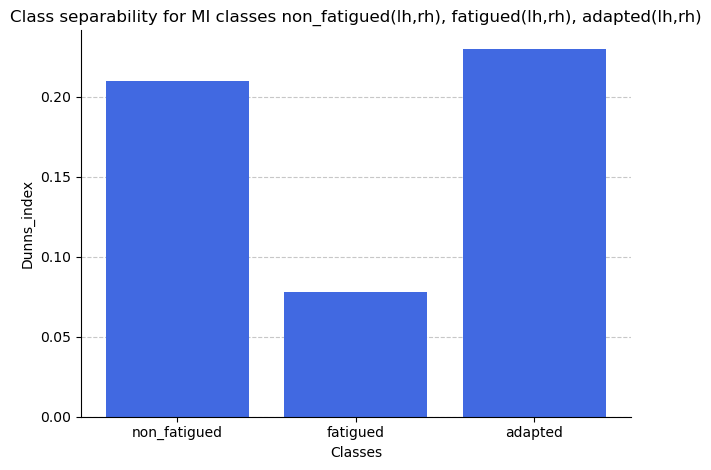

In [35]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual values)
d1 = 0.21
d2 = 0.078
d3 = 0.23

# Labels for the bars
labels = ['non_fatigued', 'fatigued', 'adapted']

# Values for the bars
values = [d1, d2, d3]

# Create a figure and axis
fig, ax = plt.subplots()

# Create the bar plot
bars = ax.bar(labels, values, color='royalblue')

# Add labels and a title
ax.set_xlabel('Classes')
ax.set_ylabel('Dunns_index')
ax.set_title('Class separability for MI classes non_fatigued(lh,rh), fatigued(lh,rh), adapted(lh,rh)')

# Adding data values on top of the bars
for bar in bars:
    height = bar.get_height()


# Customize the appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Adjust the layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


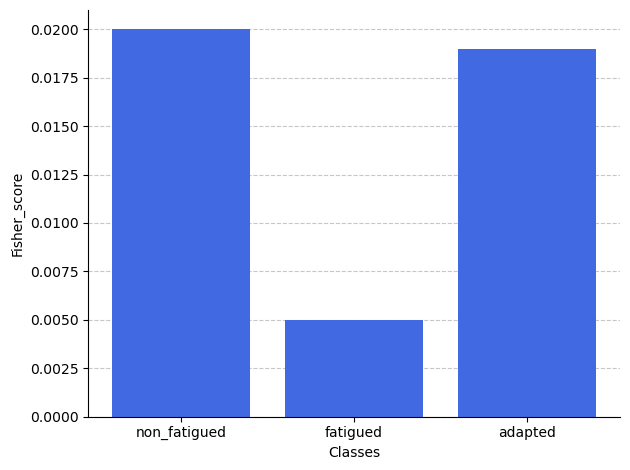

In [34]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual values)
d1 = 0.02
d2 = 0.005
d3 = 0.019

# Labels for the bars
labels = ['non_fatigued', 'fatigued', 'adapted']

# Values for the bars
values = [d1, d2, d3]

# Create a figure and axis
fig, ax = plt.subplots()

# Create the bar plot
bars = ax.bar(labels, values, color='royalblue')

# Add labels and a title
ax.set_xlabel('Classes')
ax.set_ylabel('Fisher_score')


# Adding data values on top of the bars
for bar in bars:
    height = bar.get_height()
    #ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
    #            xytext=(0, 3),  # 3 points vertical offset
    #           textcoords="offset points",
    #            ha='center', va='bottom')

# Customize the appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Adjust the layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
X_rh_f.shape 

(6, 3, 750)